In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

In [2]:
M = 101
N = 110
x = np.linspace(0, 1, M)

In [3]:
def curve_generator(x):
    model = Gaussian(dim =1,  var =3, len_scale= 0.3)
    srf= SRF(model)
    f = srf.structured([x])
    return f

U = np.concatenate([curve_generator(x)[np.newaxis,...] for _ in range(N) ]).T

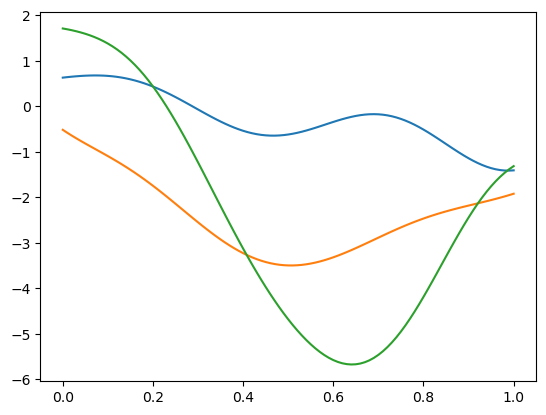

In [4]:
plt.plot(x, U[:, 2:5])
plt.show()

In [5]:
def integrate_function(f):
    result = np.zeros_like(f)
    result[0]=0
    for i in range(1, len(f)):
        result[i]= integrate.simps(f[:i+1],x[:i+1])
    return result

/tmp/ipykernel_1775937/3954524871.py:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  result[i]= integrate.simps(f[:i+1],x[:i+1])


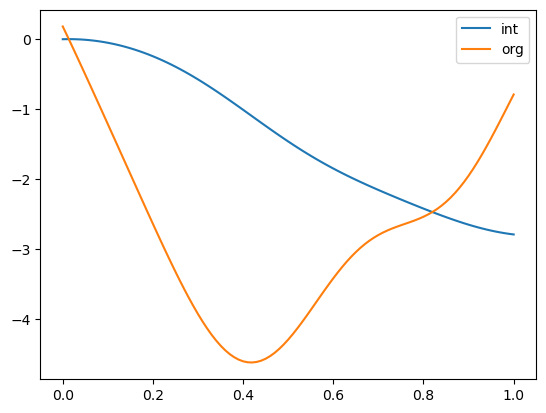

In [6]:
f = U[:, 1]
f_int = integrate_function(f)
plt.plot(x, f_int, label='int')
plt.plot(x, f, label='org')
plt.legend()
plt.show()

In [7]:
S = np.zeros((M,N))
for i in range(N):
    S[:,i] = integrate_function(U[:,i])

/tmp/ipykernel_1775937/3954524871.py:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  result[i]= integrate.simps(f[:i+1],x[:i+1])


In [8]:
U.T.shape

(110, 101)

In [65]:
class DeepONetDS(torch.utils.data.Dataset):
    def __init__(self, U, X, S):
        torch.utils.data.Dataset.__init__(self)
        self.U = U
        self.X = X
        self.S = S
        self.M = X.shape[0]
    def __len__(self):
        return self.U.shape[0] * self.U.shape[1]
    def __getitem__(self, idx):
        m = idx%self.M
        n = idx//self.M
        return self.U[n,:], self.X[m], self.S[n,m].reshape([1,])

_U = torch.tensor(U.T, dtype=torch.float32)
U_train, U_test = _U[:100], _U[100:]

_S = torch.tensor(S.T, dtype=torch.float32)
S_train, S_test = _S[:100], _S[100:]

X = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

train_ds = DeepONetDS(U_train, X, S_train)
test_ds = DeepONetDS(U_test, X, S_test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

In [69]:
class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons =20):
        super(DeepONet, self).__init__()
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.neurons = neurons
        
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()
    
    def branch_network(self):
        branch = nn.Sequential(
            nn.Linear(self.in1, self.neurons), 
            nn.ReLU(), 
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons),
        )
        return branch
        
    def trunk_network(self):
        trunk = nn.Sequential(
            nn.Linear(self.in2, self.neurons), 
            nn.ReLU(), 
            nn.Linear(self.neurons, self.neurons), 
            nn.ReLU(), 
            nn.Linear(self.neurons, self.neurons), 
            nn.ReLU(), 
            nn.Linear(self.neurons, self.output_neurons),
        )
        return trunk
        
    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.einsum("bi, bi->b", x1, x2)
        x = torch.unsqueeze(x,1)
        return x

In [98]:
model = DeepONet(neurons=40, in1= M, in2=1)

loss = nn.MSELoss()

optimizer =torch.optim.Adam(model.parameters(), lr=0.001)

In [99]:
train_losses = []
epochs = 2000

for i in range(epochs):
    l_total = 0
    for u_batch, x_batch, s_batch in train_dl:
        model.train()
        optimizer.zero_grad()
        y_pred = model(u_batch,x_batch)
        
        l= loss(y_pred, s_batch)
        l_total += l.item()
        l.backward()
        optimizer.step()
    
    l_total = l_total/len(train_dl)
    train_losses.append(l_total)
    
    if i%20 ==0:
        print("Epoch: ", i ,"/", epochs, "loss: ", l_total)

Epoch:  0 / 2000 loss:  0.072158522900972
Epoch:  20 / 2000 loss:  0.0006011183072644863


KeyboardInterrupt: 

In [94]:
my_func = lambda x: np.tan(x/10+.1) + np.cos(10*x)
inter = lambda x : np.sin(10*x)/10 + 5*np.log(np.tan(0.1*x + .1)**2+1)
u_t = my_func(x)
s_t = inter(x)

with torch.no_grad():
    p = model(torch.tensor(u_t, dtype=torch.float32).unsqueeze(0), X)

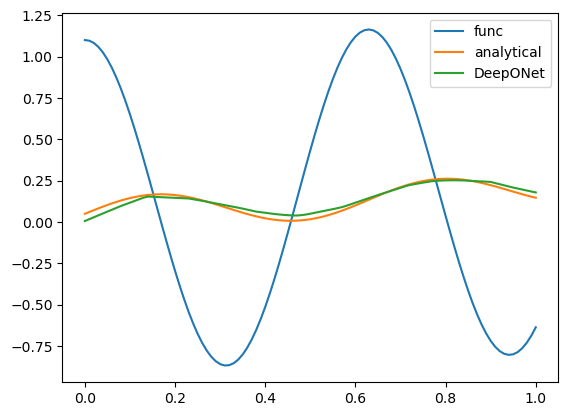

In [97]:
plt.plot(x, u_t, label = "func")
plt.plot(x, s_t, label = "analytical")
plt.plot(x, p, label = "DeepONet")
plt.legend()